# Single assay logistic regression example

In this notebook I pursue two different modeling approaches, both using Logistic regression as the ultimate classifier. The first is frequentist l2 penalized logistic regression (aka Ridge logistic regression) as implemented in scikit-learn. The second is bayesian logistic regression as implemented in PyMC, using the l2 penalty parameter obtained from the  frequentist model as the variance of gaussian prior for the regression coefficients. The purpose of this was to show equivalency between the two computational approaches.

I performed an 80/20 train/test split and used that for training and testing both approaches. The l2 pentalty parameter was obtained using 5-fold cross validation. In addition, I built frequentist logistic regression models using not class weight and using class weights to effectively balance the classes.

In [ ]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

import pymc as pm
import aesara.tensor as T
import arviz as az

In [3]:
tox21_two_assays = pd.read_csv("../data/two-assay-example.csv").drop_duplicates(subset=['PROTOCOL_NAME', 'SAMPLE_NAME'])

In [16]:
tox21_two_assays['CHANNEL_OUTCOME'].unique()

array(['inactive', 'active antagonist'], dtype=object)

In [6]:
tox21_two_assays['PROTOCOL_NAME'].unique()

array(['tox21-ar-mda-kb2-luc-agonist-p3',
       'tox21-ar-mda-kb2-luc-antagonist-p1'], dtype=object)

In [8]:
one_assay = tox21_two_assays.loc[tox21_two_assays['PROTOCOL_NAME']=='tox21-ar-mda-kb2-luc-agonist-p3']

In [10]:
one_assay.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,...,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000
mean,9.561479,-0.885280,9.563873,0.313707,0.536344,260.316715,243.707785,259.898906,93.603436,0.004399,...,0.032852,0.035739,0.007423,0.005498,0.001924,0.011959,0.001787,0.009347,0.687285,0.027904
std,3.121543,1.705481,3.122079,0.458291,0.179913,141.808922,134.797015,141.608124,50.729841,0.079401,...,0.199376,0.215787,0.088986,0.075788,0.043829,0.109965,0.045376,0.107054,2.325150,0.177562
min,0.000000,-10.657407,0.000000,0.000000,0.015845,30.026000,28.010000,30.010565,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.287593,-1.199900,8.287593,0.039288,0.418655,160.172000,148.120000,160.003150,58.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.459210,-0.410420,10.471837,0.162037,0.536584,228.208000,212.167000,227.949476,82.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.753061,0.064157,11.753061,0.403150,0.664713,327.460500,306.842000,327.075979,118.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.291804,2.120000,17.291804,8.764932,0.944994,1550.188000,1505.836000,1549.713303,544.000000,3.000000,...,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,35.000000,4.000000


## Train/test split

These data will be used for all the subsequent models

In [343]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)

scaler = StandardScaler().fit(one_assay.iloc[:,3:])
X = scaler.transform(one_assay.iloc[:,3:])
y = pd.factorize(one_assay.CHANNEL_OUTCOME)
X_train, X_test, y_train, y_test = train_test_split(X, y[0], test_size=0.20, shuffle=True)

In [344]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([5185,  635]))
(array([0, 1]), array([1291,  164]))


## Frequentist l2-penalized logistic regression

In [345]:
logistic_cv_unbalanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight=None).fit(X_train, y_train)
logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)

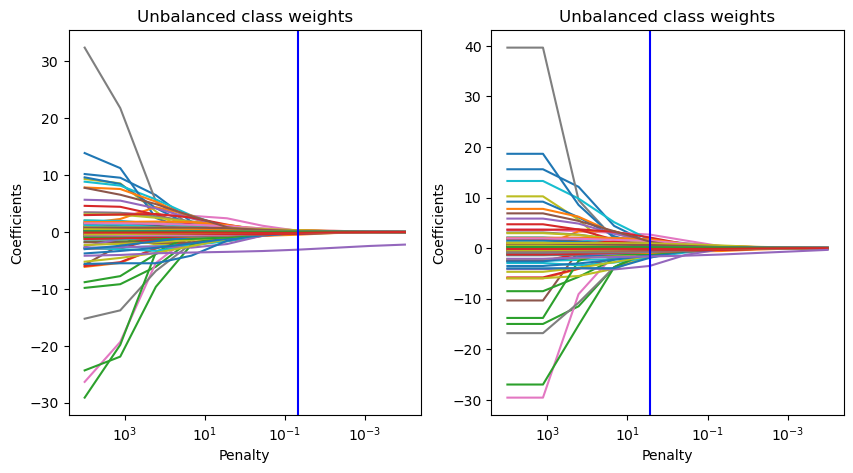

In [363]:
fig, (ax, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
ax.set_xlabel("Penalty")
ax.set_ylabel("Coefficients")
ax.set_title("Model w/o balanced class weights")

ax1.plot(logistic_cv_balanced.Cs_, logistic_cv_balanced.coefs_paths_[1].mean(axis=0))
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x =logistic_cv_balanced.C_, color = 'b', label = 'axvline - full height')
ax1.set_xlabel("Penalty")
ax1.set_ylabel("Coefficients")
ax1.set_title("Model w/o balanced class weights")


plt.show()

In [364]:
y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
y_pred_balanced = logistic_cv_balanced.predict(X_test)

In [365]:
print("Unbalanced model report")
print(classification_report(y_test,y_pred_unbalanced))

Unbalanced model report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1291
           1       0.67      0.35      0.46       164

    accuracy                           0.91      1455
   macro avg       0.79      0.67      0.71      1455
weighted avg       0.89      0.91      0.89      1455



In [366]:
print("Balanced model report")
print(classification_report(y_test,y_pred_balanced))

Balanced model report
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1291
           1       0.35      0.77      0.48       164

    accuracy                           0.81      1455
   macro avg       0.66      0.80      0.68      1455
weighted avg       0.90      0.81      0.84      1455



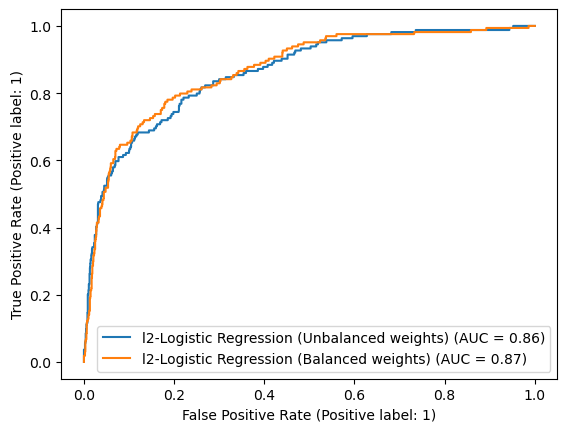

In [373]:
ax = plt.gca()

RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

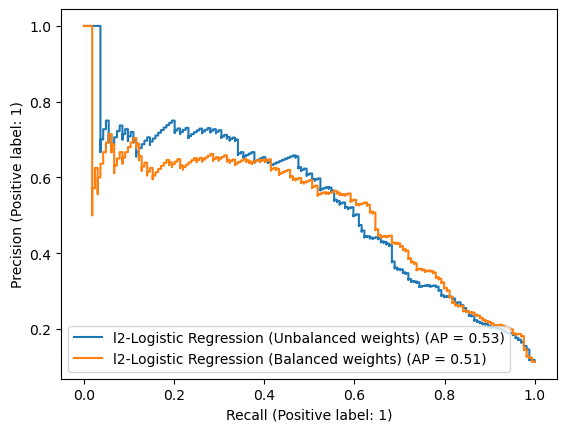

In [374]:
ax = plt.gca()

PrecisionRecallDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

plt.show()

In [375]:
y_test.mean()

0.11271477663230241

### Performance summary 
From an overall point of view, themodels are very similar in terms of performance as can be seen in the ROC curves. However, the balanced model has better precision for the inactive compounds and better recall of active (toxic compounds). Depending on the circumstances, one might prefer the balanced model as it is more likely to predict a compound to be toxic. If the goal was to only remove highly toxic compound prior to a bioassay, the unbalanced model would be prefered. However, if the goal was to select top hits with lowest likelihood of toxicity then the balanced model would be preferred. If high recall of toxic compounds is the goal then choose the balanced model, but there will be tradeoff of labeling some non-toxic compounds as toxic.

## Bayesian logistic regression
I will use the square root of the C parameter from sklearn logistic regression models as the prior standard deviation in the bayesian model.

In [378]:
#Need to add intercept column for algebra to work in PyMC
X_train_bayes = np.insert(X_train,0,1,axis=1)

In [414]:
np.sqrt(logistic_cv_unbalanced.C_)

array([0.21544347])

In [415]:
with pm.Model() as bayesian_logistic_model:
    betas = pm.Normal('betas', mu=0.0, sigma=np.sqrt(logistic_cv_unbalanced.C_), shape=X_train_bayes.shape[1])
    p = 1.0 / (1.0 + T.exp(-T.dot(X_train_bayes, betas)))
    likelihood = pm.Bernoulli('likelihood', p, observed=y_train)
    
with bayesian_logistic_model:
    bayes_logit_trace = pm.sample(500,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 439 seconds.


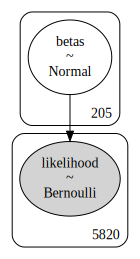

In [407]:
pm.model_to_graphviz(bayesian_logistic_model)

In [416]:
bayesian_logistic_model

In [417]:
beta_est = az.summary(bayes_logit_trace,"betas", kind="stats")

In [418]:
beta_est

,mean,sd,hdi_3%,hdi_97%
betas[0],-2.875,0.069,-2.999,-2.751
betas[1],0.107,0.161,-0.187,0.425
betas[2],-0.136,0.101,-0.320,0.055
betas[3],0.100,0.164,-0.205,0.404
betas[4],-0.110,0.089,-0.276,0.058
...,...,...,...,...
betas[200],0.053,0.057,-0.051,0.159
betas[201],0.075,0.039,0.001,0.146
betas[202],0.058,0.053,-0.048,0.152
betas[203],0.039,0.087,-0.127,0.191


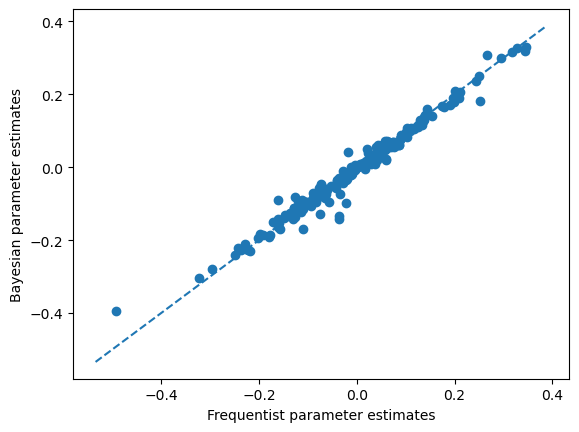

In [423]:
def abline(slope, intercept):
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--')
    
plt.scatter(logistic_cv_unbalanced.coef_[0],beta_est['mean'][1:])
plt.ylabel("Bayesian parameter estimates")
plt.xlabel("Frequentist parameter estimates")
abline(1, 0) 
plt.show()

In [424]:
np.corrcoef(logistic_cv_unbalanced.coef_[0],beta_est['mean'][1:])


array([[1.        , 0.98706981],
       [0.98706981, 1.        ]])

The above figure demonstrates a proof of the theoretical equivalence between frequentist penalized regression and bayesian regression. The parameters are not exactly identical in part because the bayesian MCMC procedure is non-deterministic and I ran only 4 chains to obtain 500 posterior samples; if we ran many more chains to obtain many more samples the correlation would tighen even further(although the correlation is already 0.99).

## Parking lot

One interesting finding from the ridge regression is that in the unbalanced class model, one feature in particular retains a robust non-zero coefficient even when the penalization parameter is large. This feature is the Fraction of SP3 hybridized carbon atoms, FCSP3. A recent review of the literature suggest that FCSP3 is a strong indicator of "drug-likeness" [1](https://www.sciencedirect.com/science/article/pii/S135964462030297X?via%3Dihub#sec0055). 

The tox21 library is composed of a combination of approved drug molecules and environmental toxins. Approved drugs should not be highly cytotoxic, except for cytotoxic chemotherapy drugs. Therefore, this association could be an artefact of the tox21 library composition. The library is a mix of approved drugs and environmental toxins. The approved drugs should be generally less cytotoxic, except for cytotoxic chemotherapy agents and even those should be somewhat cell type specific. If FSP3 is a known marker of "drug-likeness" then the negative assocation between FSP3 and cytotoxicity could just be due to high FSP3 in the approved drugs.

To tease apart whether FSP3 is causally related to reduced cytotoxicity,we can use the knowledge of which compounds are drugs and which are not. The hypothesis put forth regarding why FSP3 is a drug-likeness indicator include that this parameter increases solubility or enhanced 3D complexity. Those two hypothesis focus on the positive relationship between FSP3 and efficacy, no mention of the possibility of a negative relationship with toxicity. We can test this hypothesis with current data in hand. This result will followed up in another analysis

In [ ]:
import statsmodels.api as sm
import statsmodels.tools as tools
from statsmodels.stats.outliers_influence import variance_inflation_factor    

In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = one_assay.iloc[:,3:].columns


In [252]:
log_reg = sm.Logit(y[0], tools.add_constant(X[:,np.argmin(logistic_cv.coef_)])).fit(method='bfgs')
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.338426
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7275
Model:                          Logit   Df Residuals:                     7273
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                 0.02233
Time:                        15:46:21   Log-Likelihood:                -2462.0
converged:                       True   LL-Null:                       -2518.3
Covariance Type:            nonrobust   LLR p-value:                 2.816e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1583      0.040    -5

In [ ]:

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + str(X.iloc[:, variables].columns[maxloc]) +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

X_df = pd.DataFrame(X)
X_df.columns =  one_assay.columns[3:]
X_vif_reduced = calculate_vif_(X_df)

In [ ]:
X_int = tools.add_constant(X)
log_reg = sm.Logit(y[0],X_int).fit(method='bfgs',maxiter=10000)
print(log_reg.summary())